In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pandas as pd
import seaborn as sns
import tqdm
from skimage import feature
from skimage.feature import hog

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             classification_report, confusion_matrix, roc_auc_score)
from sklearn.model_selection import (StratifiedKFold, train_test_split, 
                                     GridSearchCV, cross_val_score)
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.multiclass import OneVsRestClassifier

### Preprocessing

In [2]:
# Read data
style = pd.read_csv('../input/fashion-product-images-small/styles.csv', nrows=10000, error_bad_lines=False)
#style['image'] = style.apply(lambda row: str(row['id'])+'.jpg', axis=1)
style = style.drop(['year','season','gender','subCategory','articleType',
                    'baseColour','usage','productDisplayName'], axis=1)

style.dropna(how='any', inplace=True)
style.reset_index(drop=True, inplace=True)
style.tail()

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\n'


,id,masterCategory
9995,10748,Footwear
9996,37956,Footwear
9997,40038,Accessories
9998,38122,Apparel
9999,59929,Apparel


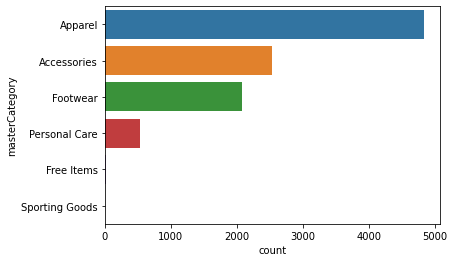

In [3]:
sns.countplot(y=style.masterCategory)
#plt.xticks(rotation=90)
plt.show()

In [4]:
file_images=[]
dir = '../input/fashion-product-images-small/images/'
for file in os.listdir(dir):
    id = file.split('.')[0]
    path = os.path.join(dir+file)
    img = cv.imread(path, cv.IMREAD_GRAYSCALE)
    img_resize = cv.resize(img, (60, 80), interpolation=cv.INTER_AREA)
    file_images.append([id, img_resize])

print(len(file_images))

44441


In [5]:
# Convert to DataFrame
labels_df = pd.DataFrame(file_images, columns=['id','image'])
labels_df['id'] = labels_df['id'].astype(int)    # Make sure id columns dtype is int
labels_df.head()

,id,image
0,31973,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
1,30778,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
2,19812,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
3,22735,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
4,38246,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."


In [6]:
# concatenate based on id
data = pd.merge(style, labels_df, how='left', on=['id'])
data.dropna(how='any', inplace=True)
data.reset_index(drop=True, inplace=True)
data.tail()

,id,masterCategory,image
9994,10748,Footwear,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
9995,37956,Footwear,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
9996,40038,Accessories,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
9997,38122,Apparel,"[[255, 255, 255, 255, 255, 255, 255, 254, 255,..."
9998,59929,Apparel,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."


In [7]:
# Label Encoder
le = LabelEncoder()
data['label'] = le.fit_transform(data.masterCategory)
data.head()

,id,masterCategory,image,label
0,15970,Apparel,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",1
1,39386,Apparel,"[[255, 255, 255, 255, 255, 255, 255, 255, 247,...",1
2,59263,Accessories,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",0
3,21379,Apparel,"[[255, 255, 255, 255, 255, 255, 255, 255, 254,...",1
4,53759,Apparel,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",1


### Feature Extraction

In [8]:
train_images = np.stack(data.image.values,axis=0)
print(train_images.shape)

(9999, 80, 60)


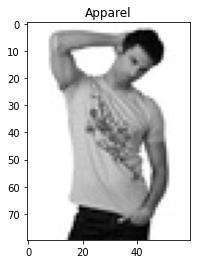

In [9]:
random_sample = np.random.randint(0,9999)
plt.imshow(train_images[random_sample], cmap='gray')
plt.title(data.masterCategory[random_sample])
plt.show()

In [10]:
# HOG
hog_images = []
hog_features = []
for i in train_images:
    #blur = cv.GaussianBlur(image,(5,5),0)
    fd, hog_image = hog(i, orientations=9, 
                        pixels_per_cell=(8,8),cells_per_block=(2,2), 
                        block_norm= 'L2', visualize=True)
    
    hog_images.append(hog_image)
    hog_features.append(fd)

hog_features = np.array(hog_features)
hog_features.shape

(9999, 1944)

### Model

In [11]:
x_train, x_test, y_train, y_test = train_test_split(hog_features, data.label, 
                                                    stratify=data.label, 
                                                    test_size=.2,shuffle=True)
print(x_train.shape)
print(x_test.shape)

(7999, 1944)
(2000, 1944)


In [12]:
# SVM
start = time.perf_counter()
# Validation
svm = SVC()
cv = StratifiedKFold(n_splits=10)
validation = cross_val_score(svm, x_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)

# Training
svm = SVC(probability=True)
svm.fit(x_train, y_train)
y_pred_train = svm.predict(x_train)
y_pred_test = svm.predict(x_test)    # Testing

elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


Elapsed 350.355 seconds.


In [13]:
print('Accuracy_Val : {:.4f}\n'.format(validation.mean()))

print('Accuracy_test : {:.4f}'.format(accuracy_score(y_test, y_pred_test)), 
      'Precision_test : {:.4f}'.format(precision_score(y_test, y_pred_test, average='macro')), 
      'Recall_test : {:.4f}'.format(recall_score(y_test, y_pred_test, average='macro')), 
      'F1-Score : {:.4f}'.format(f1_score(y_test, y_pred_test, average='macro')))

# Classification report
from sklearn.metrics import classification_report
#target_names = ['Apparel', 'Accessories', 'Footwear', 'Personal Care', 'Free Items', 'Sporting Goods']
print('\nclassification report testing : \n', classification_report(y_test, y_pred_test))

#print('\nPR_AUC crackles: %.3f' % auc_score_svm)
print('Elapsed %.3f seconds.' % elapsed)

Accuracy_Val : 0.9799

Accuracy_test : 0.9810 Precision_test : 0.7823 Recall_test : 0.7809 F1-Score : 0.7816

classification report testing : 
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       507
           1       0.98      0.99      0.99       966
           2       1.00      0.99      1.00       415
           3       0.00      0.00      0.00         5
           4       0.96      0.95      0.96       107

    accuracy                           0.98      2000
   macro avg       0.78      0.78      0.78      2000
weighted avg       0.98      0.98      0.98      2000

Elapsed 350.355 seconds.


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
